In [3]:
import statsmodels.api as sm
import pandas as pd
import numpy as np

In [4]:
df = pd.read_csv("On_Time_Marketing_Carrier_On_Time_Performance_(Beginning_January_2018)_2025_1.csv")

/tmp/ipython-input-1953331813.py:1: DtypeWarning: Columns (11,13,78,85,86,93) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("On_Time_Marketing_Carrier_On_Time_Performance_(Beginning_January_2018)_2025_1.csv")


In [5]:
df.head()

,Year,Quarter,Month,DayofMonth,DayOfWeek,FlightDate,Marketing_Airline_Network,Operated_or_Branded_Code_Share_Partners,DOT_ID_Marketing_Airline,IATA_Code_Marketing_Airline,...,Div5Airport,Div5AirportID,Div5AirportSeqID,Div5WheelsOn,Div5TotalGTime,Div5LongestGTime,Div5WheelsOff,Div5TailNum,Duplicate,Unnamed: 119
0,2025,1,1,14,2,2025-01-14,DL,DL,19790,DL,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN
1,2025,1,1,15,3,2025-01-15,DL,DL,19790,DL,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN
2,2025,1,1,16,4,2025-01-16,DL,DL,19790,DL,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN
3,2025,1,1,17,5,2025-01-17,DL,DL,19790,DL,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN
4,2025,1,1,20,1,2025-01-20,DL,DL,19790,DL,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN


In [6]:
# Identify columns that start with 'div' but are NOT 'diverted'
cols_to_drop = [col for col in df.columns if col.startswith('Div') and col != 'Diverted']

# Drop the identified columns
df_cleaned = df.drop(columns=cols_to_drop)
df_cleaned

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 599013 entries, 0 to 599012
Data columns (total 75 columns):
 #   Column                                              Non-Null Count   Dtype  
---  ------                                              --------------   -----  
 0   Year                                                599013 non-null  int64  
 1   Quarter                                             599013 non-null  int64  
 2   Month                                               599013 non-null  int64  
 3   DayofMonth                                          599013 non-null  int64  
 4   DayOfWeek                                           599013 non-null  int64  
 5   FlightDate                                          599013 non-null  object 
 6   Marketing_Airline_Network                           599013 non-null  object 
 7   Operated_or_Branded_Code_Share_Partners             599013 non-null  object 
 8   DOT_ID_Marketing_Airline                            599013 non-n

# Data Processing, Engineering & EDA

Here's a sample paragraph about data engineering:

In [7]:
df.groupby("Month")["Tail_Number"].apply(lambda x: x.notna().mean())

,Tail_Number
Month,
1,0.993546


In [8]:
df_jan = df[df["Month"] == 1].copy()
df_jan = df_jan[df_jan["Tail_Number"].notna()]

In [9]:
def clean_time(x):
    # convert float → int → string
    if pd.isna(x):
        return None
    x = str(int(x))          # "1401.0" → 1401 → "1401"
    return x.zfill(4)        # "701" → "0701"

df_jan = df[df["Month"] == 1].copy()

df_jan["DepTime_clean"] = df_jan["DepTime"].apply(clean_time)
df_jan["ArrTime_clean"] = df_jan["ArrTime"].apply(clean_time)
df_jan["CRSDepTime_clean"] = df_jan["CRSDepTime"].apply(clean_time)
df_jan["CRSArrTime_clean"] = df_jan["CRSArrTime"].apply(clean_time)


In [10]:
df_jan["dep_dt"] = pd.to_datetime(
    df_jan["FlightDate"].astype(str) + " " + df_jan["DepTime_clean"],
    format="%Y-%m-%d %H%M",
    errors="coerce"
)

df_jan["arr_dt"] = pd.to_datetime(
    df_jan["FlightDate"].astype(str) + " " + df_jan["ArrTime_clean"],
    format="%Y-%m-%d %H%M",
    errors="coerce"
)


fix post midnight arrivals

In [11]:
mask_midnight = df_jan["ArrTime_clean"] < df_jan["CRSDepTime_clean"]
df_jan.loc[mask_midnight, "arr_dt"] += pd.Timedelta(days=1)

In [12]:
df_sorted = df_jan.sort_values(["Tail_Number", "dep_dt"])

# Build arrivals table
arrivals = df_sorted[["Tail_Number", "arr_dt", "ArrDelay", "Origin", "Dest"]].rename(
    columns={"arr_dt": "prev_arr_dt", "ArrDelay": "prev_arr_delay", "Dest": "prev_dest"}
)

# Build departures table
departures = df_sorted[["Tail_Number", "dep_dt", "DepDelay", "Origin"
]].rename(
    columns={"dep_dt": "next_dep_dt", "Origin": "next_origin"}
)

# Drop rows where datetime is missing
arrivals = arrivals.dropna(subset=["prev_arr_dt"])
departures = departures.dropna(subset=["next_dep_dt"])

# Sort again after dropping
arrivals = arrivals.sort_values("prev_arr_dt")
departures = departures.sort_values("next_dep_dt")

pairs = pd.merge_asof(
    arrivals,
    departures,
    by="Tail_Number",
    left_on="prev_arr_dt",
    right_on="next_dep_dt",
    direction="forward",
    tolerance=pd.Timedelta("10h")
)


In [13]:
pairs = pairs.dropna(subset=["next_dep_dt"])

In [14]:
arrivals.shape, departures.shape, pairs.shape

((579715, 5), (580717, 4), (494057, 8))

In [15]:
pairs

,Tail_Number,prev_arr_dt,prev_arr_delay,Origin,prev_dest,next_dep_dt,DepDelay,next_origin
0,N629FR,2025-01-01 04:00:00,6.0,LAS,DEN,2025-01-01 05:20:00,-10.0,DEN
1,N27421,2025-01-01 04:14:00,3.0,BQN,EWR,2025-01-01 06:53:00,17.0,EWR
2,N991NK,2025-01-01 04:27:00,-21.0,SJU,MCO,2025-01-01 05:44:00,-6.0,MCO
3,N957JB,2025-01-01 04:32:00,-12.0,BQN,MCO,2025-01-01 06:48:00,28.0,MCO
4,N562AS,2025-01-01 04:34:00,-29.0,FAI,SEA,2025-01-01 06:30:00,-5.0,SEA
...,...,...,...,...,...,...,...,...
578621,N488HA,2025-01-31 23:22:00,144.0,HNL,OGG,2025-01-31 23:45:00,135.0,OGG
578633,N956DZ,2025-01-31 23:23:00,20.0,ATL,ECP,2025-01-31 23:24:00,27.0,ATL
578638,N435AW,2025-01-31 23:23:00,415.0,SGF,ORD,2025-01-31 23:58:00,558.0,ORD
578671,N879RW,2025-01-31 23:26:00,-18.0,BOS,DCA,2025-01-31 23:53:00,142.0,DCA


In [16]:
import numpy as np


# keep only same-airport turnarounds
pairs_clean = pairs[pairs["prev_dest"] == pairs["next_origin"]].copy()

# compute turn time in minutes
pairs_clean["turn_time_min"] = (pairs_clean["next_dep_dt"] - pairs_clean["prev_arr_dt"]).dt.total_seconds() / 60

# keep reasonable, positive turnarounds (e.g. 0–6h)
pairs_clean = pairs_clean[(pairs_clean["turn_time_min"] > 0) & (pairs_clean["turn_time_min"] <= 360)].copy()

pairs_clean[["prev_arr_delay","DepDelay","turn_time_min"]].describe()


,prev_arr_delay,DepDelay,turn_time_min
count,426492.000000,427057.000000,427075.000000
mean,2.653625,9.437698,78.525114
std,51.663810,40.392399,53.511360
min,-83.000000,-52.000000,1.000000
25%,-18.000000,-7.000000,49.000000
50%,-8.000000,-3.000000,64.000000
75%,6.000000,8.000000,86.000000
max,2680.000000,1748.000000,360.000000


In [17]:
# keep only rows with numeric values
pairs_reg = pairs_clean[["prev_arr_delay", "DepDelay"]].replace([np.inf, -np.inf], np.nan).dropna()

X = sm.add_constant(pairs_reg["prev_arr_delay"])
y = pairs_reg["DepDelay"]

global_model = sm.OLS(y, X).fit()

prop_slope = global_model.params["prev_arr_delay"]
prop_intercept = global_model.params["const"]
prop_r2 = global_model.rsquared

prop_slope, prop_intercept, prop_r2

(np.float64(0.373921583885214),
 np.float64(8.249008291624639),
 np.float64(0.23685747110269684))

In [18]:
bins = [-999, 0, 15, 60, 180, 9999]
labels = ["Early/on-time (≤0)", "0–15", "15–60", "60–180", ">180"]

pairs_clean["prev_bin"] = pd.cut(pairs_clean["prev_arr_delay"], bins=bins, labels=labels)

bin_stats = pairs_clean.groupby("prev_bin").agg(
    n=("DepDelay", "size"),
    mean_prev=("prev_arr_delay", "mean"),
    mean_next_dep=("DepDelay", "mean"),
    p_next_dep15=("DepDelay", lambda x: (x > 15).mean()),
    p_next_dep60=("DepDelay", lambda x: (x > 60).mean())
).reset_index()

bin_stats

/tmp/ipython-input-3932827833.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_stats = pairs_clean.groupby("prev_bin").agg(


,prev_bin,n,mean_prev,mean_next_dep,p_next_dep15,p_next_dep60
0,Early/on-time (≤0),289263,-15.545797,0.220386,0.073542,0.020729
1,0–15,62904,6.857275,7.644659,0.168209,0.030968
2,15–60,49048,31.585997,26.097547,0.588220,0.076721
3,60–180,20528,100.199240,71.845959,0.788533,0.585737
4,>180,4749,335.039798,135.177028,0.712360,0.603285


In [19]:
cols_for_merge = [
    "Tail_Number",
    "dep_dt",
    "IATA_Code_Operating_Airline",
    "Flight_Number_Operating_Airline",
    "Origin",
    "Dest"
]

df_jan_small = df_jan[cols_for_merge].drop_duplicates()

pairs_enriched = pairs_clean.merge(
    df_jan_small,
    left_on=["Tail_Number", "next_dep_dt", "next_origin"],
    right_on=["Tail_Number", "dep_dt", "Origin"],
    how="left"
)

pairs_enriched = pairs_enriched.rename(columns={
    "IATA_Code_Operating_Airline": "op_carrier",
    "Flight_Number_Operating_Airline": "op_flight"
}).drop(columns=["dep_dt"])


In [20]:
def slope_r2(group):
    # keep only numeric rows for this carrier
    g = group[["prev_arr_delay", "DepDelay"]].replace([np.inf, -np.inf], np.nan).dropna()

    # if too few data points, skip
    if len(g) < 50:
        return pd.Series({"slope": np.nan, "r2": np.nan, "n": len(g)})

    X = sm.add_constant(g["prev_arr_delay"])
    y = g["DepDelay"]

    # run regression
    model = sm.OLS(y, X).fit()

    return pd.Series({
        "slope": model.params["prev_arr_delay"],
        "r2": model.rsquared,
        "n": len(g)
    })


airline_stats = (
    pairs_enriched
    .dropna(subset=["op_carrier"])
    .groupby("op_carrier")
    .apply(slope_r2)
    .reset_index()
    .dropna(subset=["slope"])
    .sort_values("slope")
)

airline_stats


/tmp/ipython-input-1809011950.py:26: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(slope_r2)


,op_carrier,slope,r2,n
1,AA,0.237615,0.091412,48748.0
20,ZW,0.289393,0.202029,2888.0
4,C5,0.331343,0.268655,4624.0
12,OH,0.333197,0.208147,15589.0
10,MQ,0.346477,0.219325,15743.0
14,PT,0.357313,0.278054,8471.0
5,DL,0.367698,0.230361,52576.0
0,9E,0.368844,0.353233,13773.0
18,YV,0.372614,0.269780,4585.0
16,UA,0.376049,0.192335,39848.0


In [21]:
route_stats = (
    pairs_clean
    .groupby(["prev_dest", "next_origin"])
    .apply(slope_r2)
    .reset_index()
    .dropna(subset=["slope"])
)

# focus on routes with enough data
route_stats = route_stats[route_stats["n"] >= 100].sort_values("slope", ascending=False)

route_stats.head(20)   # worst propagators
route_stats.tail(20)   # most resilient routes


/tmp/ipython-input-1490317198.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(slope_r2)


,prev_dest,next_origin,slope,r2,n
183,LAX,LAX,0.277138,0.139934,11323.0
172,JFK,JFK,0.276907,0.157808,6203.0
21,ATL,ATL,0.269855,0.168265,20193.0
250,PHL,PHL,0.268647,0.143032,6260.0
87,DCA,DCA,0.267837,0.165927,8941.0
254,PIE,PIE,0.259003,0.042509,414.0
227,MSP,MSP,0.257371,0.113251,7351.0
308,SLC,SLC,0.252260,0.101104,7378.0
159,IAH,IAH,0.242588,0.108000,8931.0
91,DFW,DFW,0.242471,0.157911,18685.0


In [22]:
pairs_clean["turn_bucket"] = pd.cut(
    pairs_clean["turn_time_min"],
    bins=[0, 45, 90, 180, 600],
    labels=["<45", "45–90", "90–180", ">180"]
)

turn_stats = (
    pairs_clean
    .groupby("turn_bucket")
    .apply(slope_r2)
    .reset_index()
)

turn_stats

/tmp/ipython-input-1967989537.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby("turn_bucket")
/tmp/ipython-input-1967989537.py:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(slope_r2)


,turn_bucket,slope,r2,n
0,<45,0.498298,0.426536,82092.0
1,45–90,0.434216,0.314822,250761.0
2,90–180,0.257135,0.102968,71792.0
3,>180,0.046923,0.003424,21829.0


When aircraft arrive early or on time, the next departure is essentially clean: average next-dep delay is near zero and only 7% spill
into a 15-min delay. This confirms that airlines can reliably preserve schedule when inbound flights are healthy.

Small inbound delays (0-15 min) barely propagate: next departures average ~7.6 min late, and only 17% cross the 15-min
threshold. These are delays airlines can typically absorb with standard buffer.

Once inbound delay reaches the 15-60 min range, propagation becomes significant: next departures jump to ~26 min late, and the
probability of a 15-min delay shoots to 59%. Buffers no longer fully protect the outbound leg.

For large delays (60-180 min), the system loses stability: over 78% of next departures are 15-min late, and ~59% exceed 60
minutes.

Extreme inbound delays (>180 min) practically guarantee major outbound disruption: next departures average 135 min late, and
71% exceed the 15-min threshold. This confirms the heavy-tail behavior seen earlier and matches the steepest region of the
propagation curve.

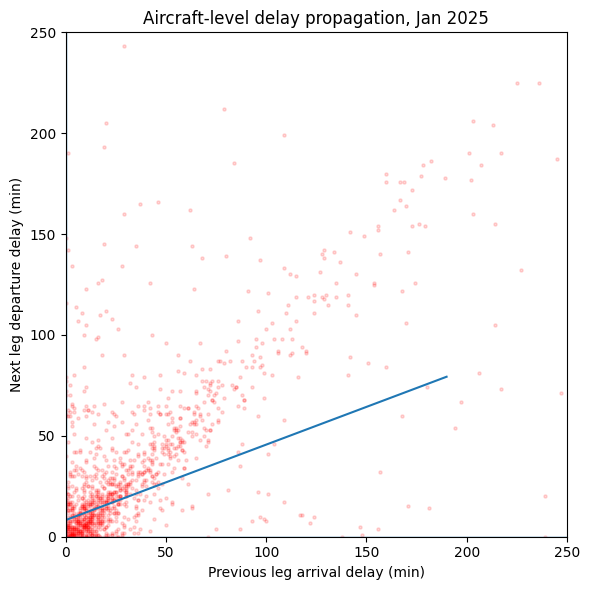

In [76]:

import matplotlib.pyplot as plt


pairs_plot = (
    pairs_clean[["prev_arr_delay", "DepDelay"]]
    .replace([np.inf, -np.inf], np.nan)
    .dropna()
)

sample = pairs_plot.sample(n=min(5000, len(pairs_plot)), random_state=0)

# Regression
X = sm.add_constant(pairs_plot["prev_arr_delay"])
y = pairs_plot["DepDelay"]
model = sm.OLS(y, X).fit()

# Line to plot
x_line = np.linspace(
    pairs_plot["prev_arr_delay"].quantile(0.01),
    pairs_plot["prev_arr_delay"].quantile(0.99),
    100
)
#y_line = model.params["const"] + model.params["prev_arr_delay"] * x_line

# Plot
plt.figure(figsize=(6, 6))
plt.scatter(sample["prev_arr_delay"], sample["DepDelay"], alpha=0.15, s=5, color='r')
plt.plot(x_line, y_line)
plt.xlim(0,250)
plt.ylim(0,250)
plt.axhline(0, linewidth=1)
plt.axvline(0, linewidth=1)
plt.xlabel("Previous leg arrival delay (min)")
plt.ylabel("Next leg departure delay (min)")
plt.title("Aircraft-level delay propagation, Jan 2025")
plt.tight_layout()
plt.show()


### Most data points cluster near the origin, confirming earlier stats: typical arrivals are within $\pm 20$ minutes and don't cause major departure issues.

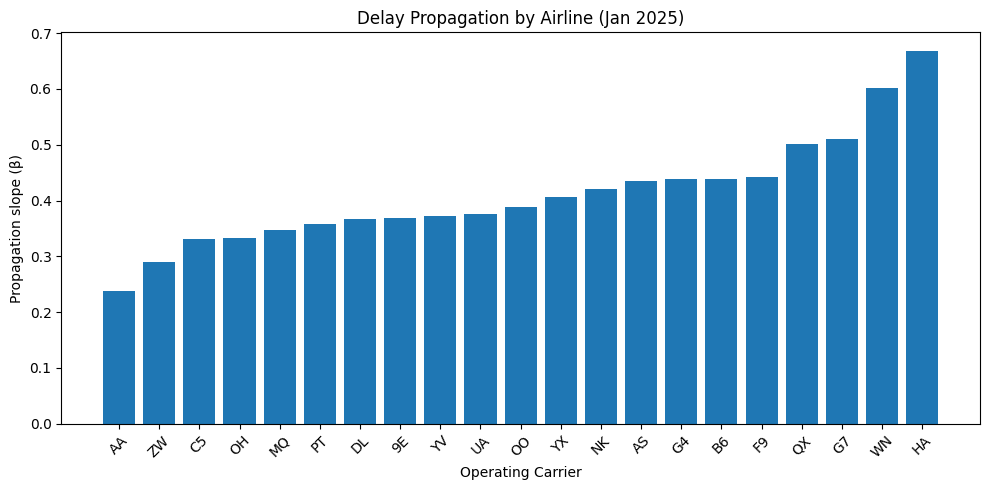

In [25]:
plt.figure(figsize=(10,5))

ordered = airline_stats.sort_values("slope")

plt.bar(ordered["op_carrier"], ordered["slope"])
plt.xticks(rotation=45)
plt.ylabel("Propagation slope (β)")
plt.xlabel("Operating Carrier")
plt.title("Delay Propagation by Airline (Jan 2025)")

plt.tight_layout()
plt.show()

### Highest Propagation of Delays: Frontier, Horizon, Allegiant, Southwest, and Hawaiian show the highest propagation, meaning delays on arrival are much more likely to flow directly into the next departure.

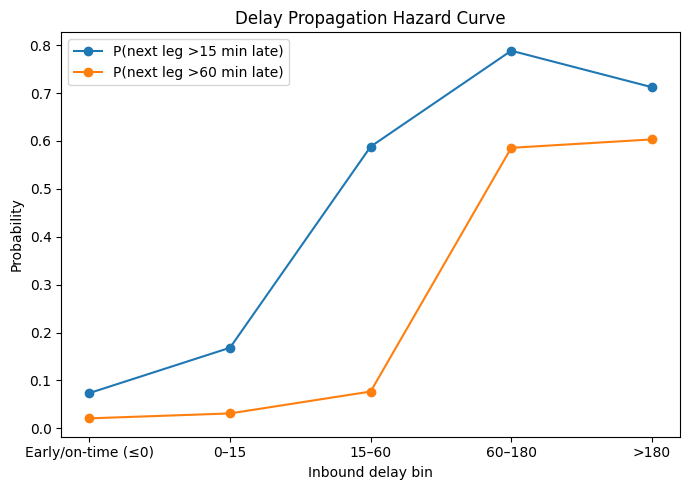

In [26]:
plt.figure(figsize=(7,5))

plt.plot(bin_stats["prev_bin"], bin_stats["p_next_dep15"], marker="o", label="P(next leg >15 min late)")
plt.plot(bin_stats["prev_bin"], bin_stats["p_next_dep60"], marker="o", label="P(next leg >60 min late)")

plt.ylabel("Probability")
plt.xlabel("Inbound delay bin")
plt.title("Delay Propagation Hazard Curve")
plt.legend()
plt.tight_layout()
plt.show()

* Once an aircraft arrives more
than 15 minutes late, the risk of
the next leg also being late jumps
sharply, crossing 50 percent in
the 15-60 bin and nearing 80
percent for 60-180.
* Major disruption begins past 60
minutes inbound, where the
chance of a 60-minute outbound
delay explodes, rising from
almost zero to nearly 60 percent.

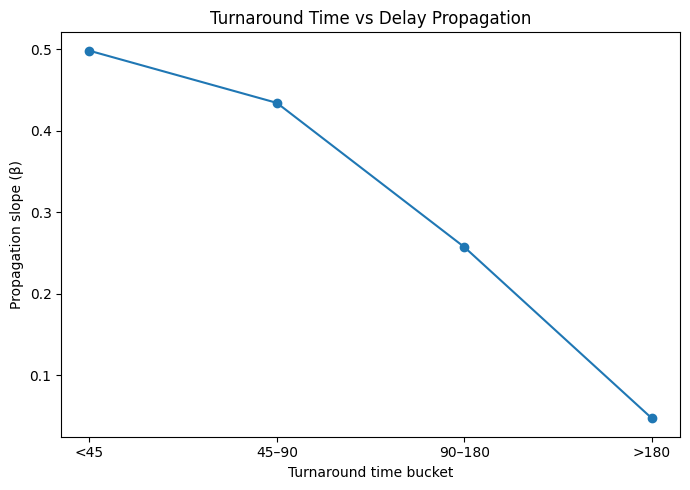

In [27]:
plt.figure(figsize=(7,5))

plt.plot(turn_stats["turn_bucket"], turn_stats["slope"], marker="o")
plt.xlabel("Turnaround time bucket")
plt.ylabel("Propagation slope (β)")
plt.title("Turnaround Time vs Delay Propagation")
plt.tight_layout()
plt.show()

* Short turns (<45 minutes) show
the highest delay propagation,
confirming that tight ground
schedules leave almost no buffer
to recover inbound delays.

* Propagation drops steadily as
turn time increases, with long
turns (>180 minutes) almost
eliminating delay carryover
entirely

/tmp/ipython-input-3656355115.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  pairs_plot.groupby("qbin")


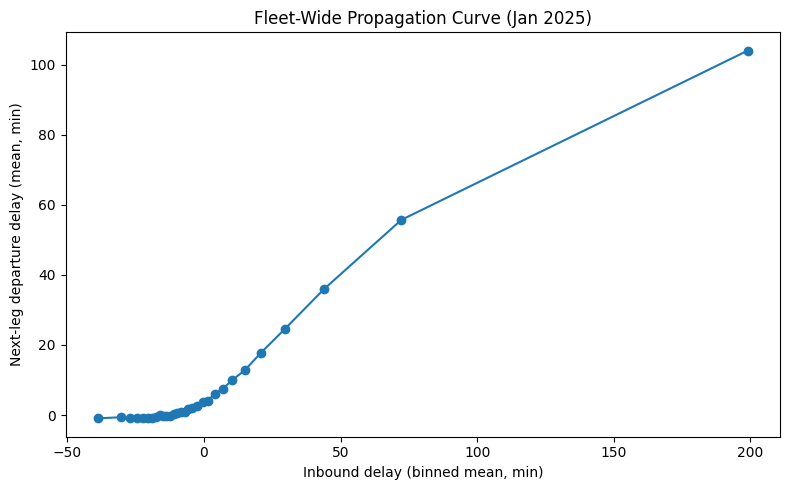

In [29]:
# Quantile bins of inbound delays
pairs_plot["qbin"] = pd.qcut(pairs_plot["prev_arr_delay"], q=30, duplicates="drop")

curve = (
    pairs_plot.groupby("qbin")
    .agg(
        mean_prev=("prev_arr_delay", "mean"),
        mean_dep=("DepDelay", "mean")
    )
    .sort_values("mean_prev")
)

plt.figure(figsize=(8,5))
plt.plot(curve["mean_prev"], curve["mean_dep"], marker="o")

plt.xlabel("Inbound delay (binned mean, min)")
plt.ylabel("Next-leg departure delay (mean, min)")
plt.title("Fleet-Wide Propagation Curve (Jan 2025)")
plt.tight_layout()
plt.show()


In [30]:
pairs.columns

Index(['Tail_Number', 'prev_arr_dt', 'prev_arr_delay', 'Origin', 'prev_dest',
       'next_dep_dt', 'DepDelay', 'next_origin'],
      dtype='object')

In [31]:
cols_for_merge = [
    "Tail_Number",
    "dep_dt",
    "IATA_Code_Operating_Airline",
    "Flight_Number_Operating_Airline",
    "Origin",
    "Dest",
    "Distance",
    "AirTime",
    "CRSElapsedTime"
]


In [32]:
df_jan_small = df_jan[cols_for_merge].drop_duplicates()

In [33]:
pairs_enriched = pairs_clean.merge(
    df_jan_small,
    left_on=["Tail_Number", "next_dep_dt", "next_origin"],
    right_on=["Tail_Number", "dep_dt", "Origin"],
    how="left"
)

pairs_enriched = pairs_enriched.rename(columns={
    "IATA_Code_Operating_Airline": "op_carrier",
    "Flight_Number_Operating_Airline": "op_flight"
}).drop(columns=["dep_dt"])


In [34]:
pairs_enriched

,Tail_Number,prev_arr_dt,prev_arr_delay,Origin_x,prev_dest,next_dep_dt,DepDelay,next_origin,turn_time_min,prev_bin,turn_bucket,op_carrier,op_flight,Origin_y,Dest,Distance,AirTime,CRSElapsedTime
0,N629FR,2025-01-01 04:00:00,6.0,LAS,DEN,2025-01-01 05:20:00,-10.0,DEN,80.0,0–15,45–90,F9,1375,DEN,PHX,602.0,93.0,126.0
1,N27421,2025-01-01 04:14:00,3.0,BQN,EWR,2025-01-01 06:53:00,17.0,EWR,159.0,0–15,90–180,UA,2438,EWR,IAH,1400.0,218.0,254.0
2,N991NK,2025-01-01 04:27:00,-21.0,SJU,MCO,2025-01-01 05:44:00,-6.0,MCO,77.0,Early/on-time (≤0),45–90,NK,3785,MCO,DTW,957.0,128.0,161.0
3,N957JB,2025-01-01 04:32:00,-12.0,BQN,MCO,2025-01-01 06:48:00,28.0,MCO,136.0,Early/on-time (≤0),90–180,B6,2876,MCO,PVD,1072.0,130.0,167.0
4,N562AS,2025-01-01 04:34:00,-29.0,FAI,SEA,2025-01-01 06:30:00,-5.0,SEA,116.0,Early/on-time (≤0),90–180,AS,376,SEA,ATL,2182.0,241.0,287.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
427072,N494HA,2025-01-31 23:10:00,174.0,HNL,LIH,2025-01-31 23:39:00,174.0,LIH,29.0,60–180,<45,HA,554,LIH,HNL,102.0,26.0,37.0
427073,N488HA,2025-01-31 23:22:00,144.0,HNL,OGG,2025-01-31 23:45:00,135.0,OGG,23.0,60–180,<45,HA,565,OGG,HNL,100.0,24.0,39.0
427074,N435AW,2025-01-31 23:23:00,415.0,SGF,ORD,2025-01-31 23:58:00,558.0,ORD,35.0,>180,<45,ZW,6021,ORD,MKE,67.0,19.0,56.0
427075,N879RW,2025-01-31 23:26:00,-18.0,BOS,DCA,2025-01-31 23:53:00,142.0,DCA,27.0,Early/on-time (≤0),<45,YX,5729,DCA,LEX,414.0,68.0,103.0


# Getting weather data

In [35]:
# 1. Get all airports that appear anywhere in the rotations
airports = sorted(
    set(pairs_enriched["prev_dest"].dropna().unique())
    | set(pairs_enriched["next_origin"].dropna().unique())
    | set(pairs_enriched["Origin_x"].dropna().unique())
    | set(pairs_enriched["Dest"].dropna().unique())
)

print("Number of airports:", len(airports))
print(airports)

Number of airports: 352
['ABE', 'ABI', 'ABQ', 'ABR', 'ABY', 'ACT', 'ACV', 'ACY', 'ADK', 'ADQ', 'AEX', 'AGS', 'AKN', 'ALB', 'ALO', 'ALW', 'AMA', 'ANC', 'APN', 'ART', 'ASE', 'ATL', 'ATW', 'AUS', 'AVL', 'AVP', 'AZA', 'AZO', 'BDL', 'BET', 'BFF', 'BFL', 'BGM', 'BGR', 'BHM', 'BIH', 'BIL', 'BIS', 'BJI', 'BLI', 'BLV', 'BMI', 'BNA', 'BOI', 'BOS', 'BPT', 'BQK', 'BQN', 'BRD', 'BRO', 'BRW', 'BTM', 'BTR', 'BTV', 'BUF', 'BUR', 'BWI', 'BZN', 'CAE', 'CAK', 'CDC', 'CDV', 'CHA', 'CHO', 'CHS', 'CID', 'CIU', 'CKB', 'CLE', 'CLL', 'CLT', 'CMH', 'CMI', 'CMX', 'COD', 'COS', 'COU', 'CPR', 'CRP', 'CRW', 'CSG', 'CVG', 'CWA', 'CYS', 'DAB', 'DAL', 'DAY', 'DCA', 'DDC', 'DEC', 'DEN', 'DFW', 'DHN', 'DIK', 'DLG', 'DLH', 'DRO', 'DSM', 'DTW', 'DVL', 'EAR', 'EAT', 'EAU', 'ECP', 'EGE', 'EKO', 'ELM', 'ELP', 'ERI', 'ESC', 'EUG', 'EVV', 'EWN', 'EWR', 'EYW', 'FAI', 'FAR', 'FAT', 'FAY', 'FCA', 'FLG', 'FLL', 'FLO', 'FNT', 'FOD', 'FSD', 'FSM', 'FWA', 'GCC', 'GCK', 'GEG', 'GFK', 'GGG', 'GJT', 'GNV', 'GPT', 'GRB', 'GRI', 'GRK', 'G

In [36]:
import pandas as pd

# Load OpenFlights airport database
url = "https://raw.githubusercontent.com/jpatokal/openflights/master/data/airports.dat"
cols = [
    "AirportID","Name","City","Country","IATA","ICAO",
    "Latitude","Longitude","Altitude","Timezone","DST","Tz","Type","Source"
]
airports_db = pd.read_csv(url, header=None, names=cols)

# Keep only airports with IATA codes
airports_db = airports_db[airports_db["IATA"].notna() & (airports_db["IATA"] != "\\N")]

airports_db = airports_db[["IATA","Latitude","Longitude"]]

airports_db.head()

,IATA,Latitude,Longitude
0,GKA,-6.081690,145.391998
1,MAG,-5.207080,145.789001
2,HGU,-5.826790,144.296005
3,LAE,-6.569803,146.725977
4,POM,-9.443380,147.220001


In [37]:
# Your airport list
airport_list = airports

# Filter only the airports in your dataset
airport_coords_df = airports_db[airports_db["IATA"].isin(airport_list)]

print("Matched airports:", airport_coords_df.shape[0])
airport_coords_df.head()


Matched airports: 350


,IATA,Latitude,Longitude
1902,PPG,-14.331000,-170.710007
2149,SPN,15.119000,145.729004
2151,GUM,13.483400,144.796005
2738,STT,18.337299,-64.973396
2739,STX,17.701900,-64.798599


In [38]:
airport_coords = dict(
    zip(
        airport_coords_df["IATA"],
        zip(airport_coords_df["Latitude"], airport_coords_df["Longitude"])
    )
)

len(airport_coords)

350

In [39]:
missing = [ap for ap in airport_list if ap not in airport_coords]
print("Missing:", missing)

Missing: ['EAR', 'XWA']


In [40]:
airport_coords["EAR"] = (40.7270, -99.0068)
airport_coords["XWA"] = (48.2594, -103.7500)

In [41]:
!pip install openmeteo-requests

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.1/167.1 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 683.2/683.2 kB 28.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 145.8/145.8 kB 13.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 394.1/394.1 kB 31.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 63.3 MB/s eta 0:00:00


In [42]:
!pip install requests_cache

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.4/61.4 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.7/70.7 kB 4.4 MB/s eta 0:00:00


In [43]:
!pip install retry-requests

In [44]:
import openmeteo_requests
import pandas as pd
import requests_cache
from retry_requests import retry
from tqdm import tqdm

# ----------------------------------------------------------------------
# Setup caching + retry logic (VERY IMPORTANT for 319 airports)
# ----------------------------------------------------------------------

cache_session = requests_cache.CachedSession('.wx_cache', expire_after=-1)
retry_session = retry(cache_session, retries=5, backoff_factor=0.2)
openmeteo = openmeteo_requests.Client(session=retry_session)

# ----------------------------------------------------------------------
# Weather API function (hourly, Jan 2025)
# ----------------------------------------------------------------------

def get_weather(lat, lon, start="2025-01-01", end="2025-01-31"):
    url = "https://archive-api.open-meteo.com/v1/archive"

    params = {
        "latitude": lat,
        "longitude": lon,
        "start_date": start,
        "end_date": end,
        "hourly": [
            "temperature_2m",
            "wind_speed_10m",
            "precipitation",
            "visibility",
            "cloud_cover"
        ],
        "timezone": "UTC"
    }

    r = openmeteo.weather_api(url, params=params)[0]
    hourly = r.Hourly()

    time_index = pd.date_range(
        start=pd.to_datetime(hourly.Time(), unit="s", utc=True),
        end=pd.to_datetime(hourly.TimeEnd(), unit="s", utc=True),
        freq=pd.Timedelta(seconds=hourly.Interval()),
        inclusive="left"
    )

    df = pd.DataFrame({"datetime": time_index})

    for i, var in enumerate(params["hourly"]):
        df[var] = hourly.Variables(i).ValuesAsNumpy()

    return df

# ----------------------------------------------------------------------
# Build weather table for ALL airports
# ----------------------------------------------------------------------

weather_list = []

print("Fetching weather for", len(airport_coords), "airports...")

for ap, (lat, lon) in tqdm(airport_coords.items()):
    try:
        df_w = get_weather(lat, lon, "2025-01-01", "2025-01-31")
        df_w["airport"] = ap
        weather_list.append(df_w)
    except Exception as e:
        print(f"Failed at {ap}: {e}")

weather_all = pd.concat(weather_list, ignore_index=True)

# ----------------------------------------------------------------------
# Save weather table locally (TO AVOID NOT TO  fetch 319 airports twice)


weather_all.to_parquet("weather_jan2025.parquet", index=False)

print("Done! Weather rows:", len(weather_all))
weather_all.head()

Fetching weather for 352 airports...


100%|██████████| 352/352 [01:13<00:00,  4.79it/s]


Done! Weather rows: 261888


,datetime,temperature_2m,wind_speed_10m,precipitation,visibility,cloud_cover,airport
0,2025-01-01 00:00:00+00:00,28.193501,9.997700,0.1,NaN,100.0,PPG
1,2025-01-01 01:00:00+00:00,28.093500,15.778518,0.7,NaN,100.0,PPG
2,2025-01-01 02:00:00+00:00,28.093500,16.208998,0.0,NaN,100.0,PPG
3,2025-01-01 03:00:00+00:00,27.843500,11.109076,0.8,NaN,100.0,PPG
4,2025-01-01 04:00:00+00:00,28.143499,13.364923,0.2,NaN,100.0,PPG


# Feature Engineering: Departure - Arrival pairs format (Adding weather data)

In [45]:
pairs = pairs_enriched.copy()
weather = weather_all

In [46]:
pairs["prev_arr_dt"] = pd.to_datetime(pairs["prev_arr_dt"], utc=True)
pairs["next_dep_dt"] = pd.to_datetime(pairs["next_dep_dt"], utc=True)
weather["datetime"] = pd.to_datetime(weather["datetime"], utc=True)

In [47]:
pairs["dep_hour"] = pairs["next_dep_dt"].dt.floor("H")
pairs["arr_hour"] = pairs["prev_arr_dt"].dt.floor("H")

/tmp/ipython-input-3449683804.py:1: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  pairs["dep_hour"] = pairs["next_dep_dt"].dt.floor("H")
/tmp/ipython-input-3449683804.py:2: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  pairs["arr_hour"] = pairs["prev_arr_dt"].dt.floor("H")


In [48]:
pairs_weather = pairs.merge(
    weather,
    left_on=["next_origin", "dep_hour"],
    right_on=["airport", "datetime"],
    how="left",
    suffixes=("", "_origin")
)

In [49]:
# prepare dest weather dataframe with suffix
weather_dest = weather.rename(columns={
    "temperature_2m": "temperature_2m_dest",
    "wind_speed_10m": "wind_speed_10m_dest",
    "precipitation": "precipitation_dest",
    "visibility": "visibility_dest",
    "cloud_cover": "cloud_cover_dest"
})

pairs_weather = pairs_weather.merge(
    weather_dest,
    left_on=["prev_dest", "arr_hour"],
    right_on=["airport", "datetime"],
    how="left"
)

In [50]:
pairs_weather[[
    "next_origin", "prev_dest",
    "temperature_2m", "wind_speed_10m", "cloud_cover",
    "temperature_2m_dest"
]].sample(10)

,next_origin,prev_dest,temperature_2m,wind_speed_10m,cloud_cover,temperature_2m_dest
180469,BWI,BWI,5.022000,12.800265,32.0,5.022000
126761,PHX,PHX,13.604000,5.762812,22.0,9.754000
144150,MIA,MIA,18.445499,9.195868,0.0,18.695499
181235,ATL,ATL,9.152500,12.362475,0.0,10.702500
280027,HPN,HPN,-17.354000,6.660000,25.0,-16.504000
101721,SAV,SAV,8.937000,11.132385,63.0,8.487000
37895,HPN,HPN,1.746000,17.313717,54.0,-0.354000
146100,CHS,CHS,3.417500,17.997299,100.0,3.417500
324166,SAN,SAN,9.786500,8.574123,100.0,8.386500
23728,SAN,SAN,12.986501,2.052316,0.0,9.386500


# Summary of the dataframe and introduction to X and Y

In [51]:
df = pairs_weather.copy()

df = df.drop(columns=[
    "visibility", "visibility_dest",   # all NaN
    "dep_hour", "arr_hour",            # helper keys
    "datetime_x", "datetime_y",        # duplicate with dep/arr
    "airport_x", "airport_y"           # just labels
])

### Target Variable: `DepDelay`

In this model, the objective is to predict the *departure delay of the next scheduled flight* operated by the same aircraft. The target variable is:

**`DepDelay`** : The number of minutes by which the next flight departs later (or earlier, if negative) than its scheduled departure time.

This variable represents the operational outcome we want to forecast, and it naturally captures **aircraft-level delay propagation**. Because the dataset includes the previous flight’s arrival delay, turn time, weather conditions, route characteristics, and aircraft identifiers, the model learns how these factors influence whether the next flight leaves on time or inherits delay from the prior segment.

Predicting `DepDelay` is the correct choice because it aligns directly with the real-world concept of propagation:  
 *If the previous flight arrived late, does the next flight operated by that same aircraft also depart late, and by how much?*

By using `DepDelay` as the target, the model quantifies the operational chain reaction of delays across an aircraft’s schedule and provides insights into resilience, recovery time, and the drivers of delay amplification.


### Feature Set (X): Operational, Temporal, and Weather Drivers of Delay Propagation



To predict the departure delay of the next flight (`DepDelay`), the model uses a comprehensive set of explanatory variables that capture how delays move through an aircraft’s schedule. These features represent three core dimensions of propagation: **previous flight performance**, **turnaround constraints**, and **external operating conditions**.

#### **1. Previous Flight Characteristics**
- **`prev_arr_dt` / `prev_arr_delay`**  
  Timestamp and arrival delay of the aircraft’s prior flight. These are the primary indicators of potential delay inheritance, as late arrivals compress ground time and increase operational pressure.
- **`prev_dest`**  
  Previous destination airport, capturing airport-specific congestion or ground delay risks.
- **`prev_bin`**, **`prev_bucket`**  
  Categorized representations of the previous arrival delay (e.g., on time, moderately late, severely late), improving model stability.

#### **2. Turnaround Dynamics**
- **`turn_time_min`**  
  Actual time between the previous arrival and the next departure. Short turn times increase the likelihood of delay propagation because they leave less buffer for aircraft servicing, cleaning, fueling, and boarding.
- **`next_dep_dt`**  
  Scheduled departure time of the next flight, enabling temporal patterns (morning vs. evening operations).

#### **3. Next Flight Operational Characteristics**
- **`next_origin`**, **`Dest`**  
  Pair of airports for the upcoming flight. These encode airport congestion levels, runway configurations, and typical delay patterns.
- **`op_carrier`**, **`op_flight`**  
  Airline operator and flight identifier, capturing airline-level operational reliability.
- **`Distance`**, **`AirTime`**, **`CRSElapsedTime`**  
  Flight distance and scheduled duration metrics influence how much time exists to recover delay once airborne.

#### **4. Weather Conditions (Departure & Arrival)**
- **`temperature_2m`, `wind_speed_10m`, `precipitation`, `cloud_cover`**  
- **`temperature_2m_dest`, `wind_speed_10m_dest`, `precipitation_dest`, `cloud_cover_dest`**  
  Weather at both the previous arrival airport and the next departure airport significantly affects taxi times, de-icing delays, ground handling efficiency, and airborne operations.

#### **5. Aircraft Identifier**
- **`Tail_Number`**  
  Links flights into true aircraft rotations, enabling the model to learn propagation chains with high fidelity.



In [53]:
numeric_cols = [
    "prev_arr_delay",
    "turn_time_min",
    "Distance",
    "AirTime",
    "CRSElapsedTime",
    "DistanceGroup",
    "DayOfWeek",
    "temperature_2m",
    "wind_speed_10m",
    "precipitation",
    "cloud_cover",
    "temperature_2m_dest",
    "wind_speed_10m_dest",
    "precipitation_dest",
    "cloud_cover_dest"
]

In [54]:
cat_cols = [
    "op_carrier",
    "prev_dest",
    "next_origin",
    "DepTimeBlk",
    "ArrTimeBlk"
]

# Weather Analysis

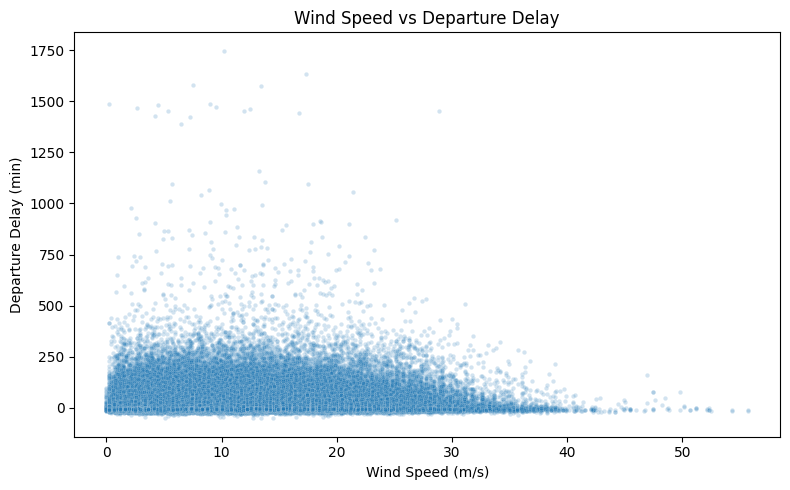

In [57]:
plt.figure(figsize=(8,5))
sns.scatterplot(
    data=df, x="wind_speed_10m", y="DepDelay",
    alpha=0.2, s=10
)
plt.title("Wind Speed vs Departure Delay")
plt.xlabel("Wind Speed (m/s)")
plt.ylabel("Departure Delay (min)")
plt.tight_layout()
plt.show()

/tmp/ipython-input-2040521966.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x="rain_bin", y="DepDelay", palette="Blues")


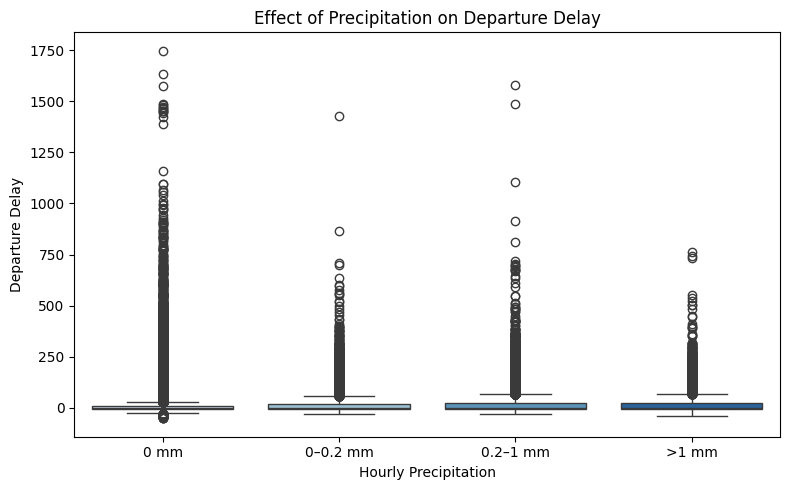

In [58]:
df["rain_bin"] = pd.cut(df["precipitation"],
                        bins=[-0.01, 0.0, 0.2, 1.0, 5.0],
                        labels=["0 mm", "0–0.2 mm", "0.2–1 mm", ">1 mm"])

plt.figure(figsize=(8,5))
sns.boxplot(data=df, x="rain_bin", y="DepDelay", palette="Blues")
plt.title("Effect of Precipitation on Departure Delay")
plt.xlabel("Hourly Precipitation")
plt.ylabel("Departure Delay")
plt.tight_layout()
plt.show()

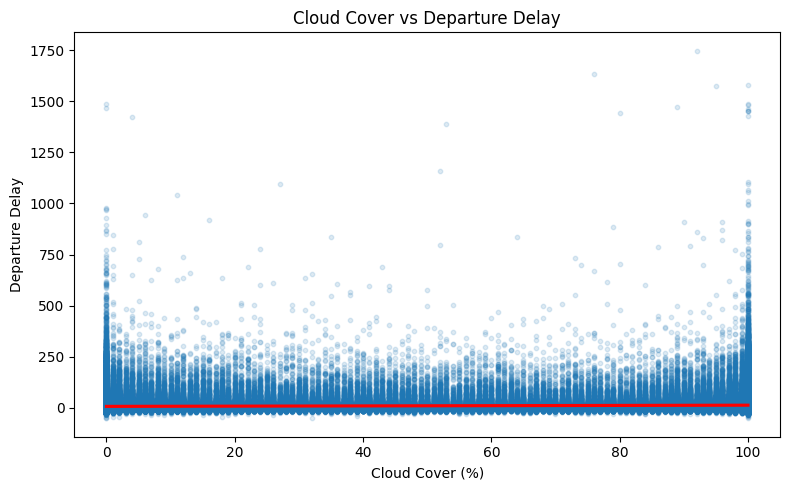

In [59]:
plt.figure(figsize=(8,5))
sns.regplot(
    data=df, x="cloud_cover", y="DepDelay",
    scatter_kws={"alpha":0.15, "s":10}, line_kws={"color":"red"}
)
plt.title("Cloud Cover vs Departure Delay")
plt.xlabel("Cloud Cover (%)")
plt.ylabel("Departure Delay")
plt.tight_layout()
plt.show()

# US MAPS
### Takes a lot of time to run (careful)

In [60]:
import folium
# Extract all origin and destination airports
airports_used = sorted(
    set(df["prev_dest"]).union(set(df["next_origin"]))
)
len(airports_used)

m = folium.Map(location=[39.5, -98.35], zoom_start=4, tiles="cartodbpositron")
for ap in airports_used:
    if ap in airport_coords:
        lat, lon = airport_coords[ap]
        folium.CircleMarker(
            location=[lat, lon],
            radius=4,
            color="blue",
            fill=True,
            fill_color="blue",
            popup=ap
        ).add_to(m)

In [61]:
routes = (
    df.groupby(["Origin_x", "Dest"])
      .size()
      .reset_index(name="count")
)

routes.head()
routes = routes[routes["Origin_x"] != routes["Dest"]]

In [62]:
import math
m = folium.Map(location=[39.5, -98.35], zoom_start=5, tiles="cartodbpositron")

for _, row in routes.iterrows():
    o = row["Origin_x"]
    d = row["Dest"]
    count = row["count"]

    if o in airport_coords and d in airport_coords:
        lat1, lon1 = airport_coords[o]
        lat2, lon2 = airport_coords[d]

        weight = max(1, math.log(count+1)*0.7)

        folium.PolyLine(
            locations=[(lat1, lon1), (lat2, lon2)],
            color="blue",
            weight=weight,
            opacity=0.45,
            tooltip=f"{o} → {d} ({count} flights)"
        ).add_to(m)
for ap in set(routes["Origin_x"]).union(routes["Dest"]):
    if ap in airport_coords:
        lat, lon = airport_coords[ap]
        folium.CircleMarker(
            location=[lat, lon],
            radius=3,
            fill=True,
            fill_color="black",
            color="black",
            popup=ap
        ).add_to(m)

# More EDA  

/usr/local/lib/python3.12/dist-packages/statsmodels/regression/linear_model.py:1782: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
/tmp/ipython-input-2003798156.py:14: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_ap.groupby("prev_dest").apply(slope_airport).reset_index()
/tmp/ipython-input-2003798156.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


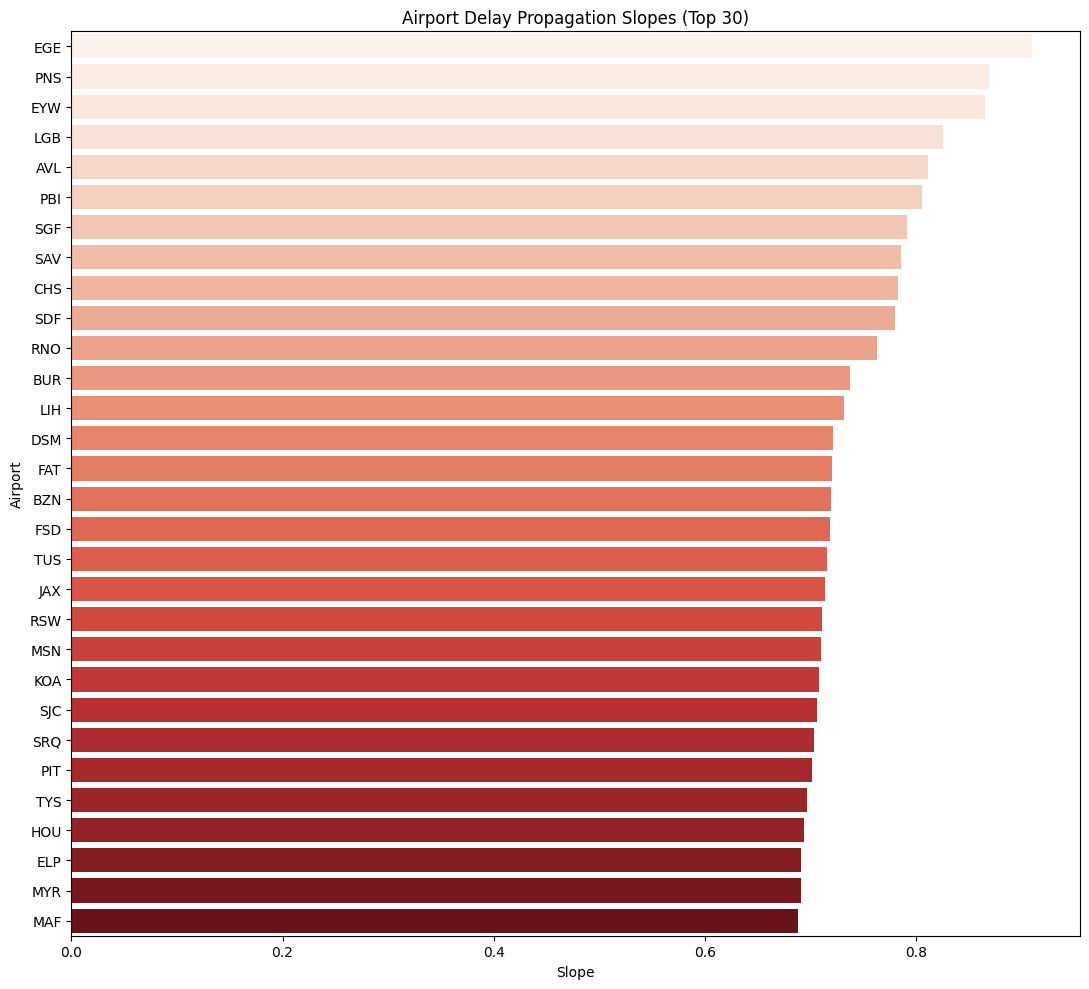

In [56]:
df_ap = df.dropna(subset=["prev_arr_delay", "DepDelay", "prev_dest"])

def slope_airport(group):
    X = sm.add_constant(group["prev_arr_delay"])
    y = group["DepDelay"]
    m = sm.OLS(y, X).fit()
    return pd.Series({
        "slope": m.params["prev_arr_delay"],
        "r2": m.rsquared,
        "n": len(group)
    })

airport_slopes = (
    df_ap.groupby("prev_dest").apply(slope_airport).reset_index()
)

airport_slopes = airport_slopes[airport_slopes["n"] > 500]

plt.figure(figsize=(11,10))
sns.barplot(
    data=airport_slopes.sort_values("slope", ascending=False).head(30),
    x="slope", y="prev_dest", palette="Reds"
)
plt.title("Airport Delay Propagation Slopes (Top 30)")
plt.xlabel("Slope")
plt.ylabel("Airport")
plt.tight_layout()
plt.show()


· Mountain, island, and leisure airports
(like EGE, EYW, PNS, AVL) sit at
the top, indicating they struggle the
most to absorb inbound delays.
· Many high-slope airports operate
with limited gates or constrained
operations, making recovery time
scarce.

· Major hubs barely appear here,
confirming that large airports
generally maintain stronger delay-
buffering capability than
small/seasonal stations.

/tmp/ipython-input-3833785892.py:16: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  carrier_slopes = df_car.groupby("op_carrier").apply(slope).reset_index()
/tmp/ipython-input-3833785892.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


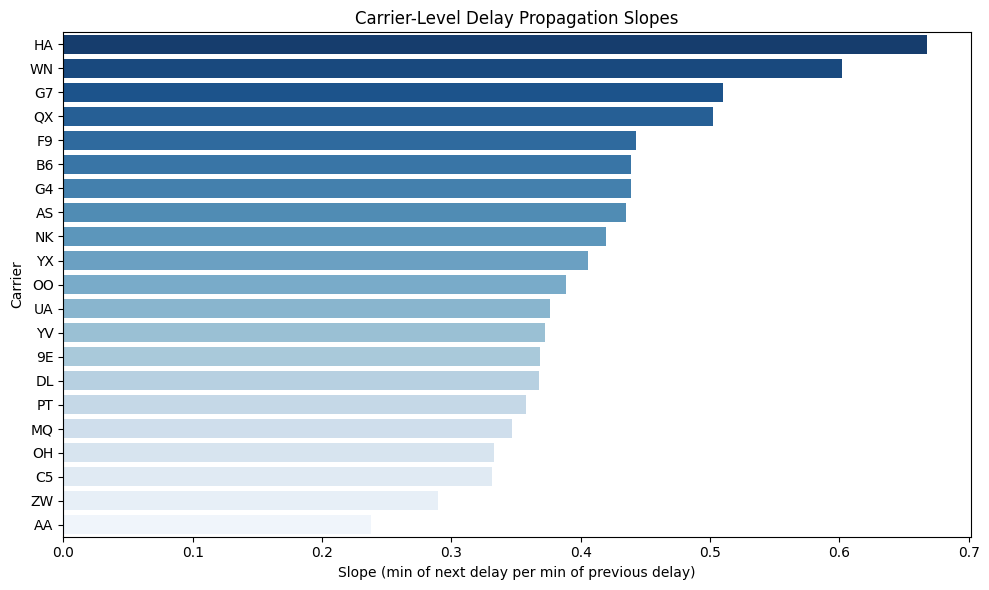

In [55]:
import seaborn as sns
import matplotlib.pyplot as plt

df_car = df.dropna(subset=["prev_arr_delay", "DepDelay", "op_carrier"])

def slope(group):
    X = sm.add_constant(group["prev_arr_delay"])
    y = group["DepDelay"]
    m = sm.OLS(y, X).fit()
    return pd.Series({
        "slope": m.params["prev_arr_delay"],
        "r2": m.rsquared,
        "n": len(group)
    })

carrier_slopes = df_car.groupby("op_carrier").apply(slope).reset_index()
carrier_slopes = carrier_slopes[carrier_slopes["n"] > 500]  # remove tiny groups

plt.figure(figsize=(10,6))
sns.barplot(
    data=carrier_slopes.sort_values("slope", ascending=False),
    x="slope", y="op_carrier", palette="Blues_r"
)
plt.title("Carrier-Level Delay Propagation Slopes")
plt.xlabel("Slope (min of next delay per min of previous delay)")
plt.ylabel("Carrier")
plt.tight_layout()
plt.show()

### Highest Propagation of Delays: Frontier, Horizon, Allegiant, Southwest, and Hawaiian show the highest propagation, meaning delays on arrival are much more likely to flow directly into the next departure.

In [63]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 427077 entries, 0 to 427076
Data columns (total 27 columns):
 #   Column               Non-Null Count   Dtype              
---  ------               --------------   -----              
 0   Tail_Number          427077 non-null  object             
 1   prev_arr_dt          427077 non-null  datetime64[ns, UTC]
 2   prev_arr_delay       426494 non-null  float64            
 3   Origin_x             427077 non-null  object             
 4   prev_dest            427077 non-null  object             
 5   next_dep_dt          427077 non-null  datetime64[ns, UTC]
 6   DepDelay             427059 non-null  float64            
 7   next_origin          427077 non-null  object             
 8   turn_time_min        427077 non-null  float64            
 9   prev_bin             426494 non-null  category           
 10  turn_bucket          427077 non-null  category           
 11  op_carrier           427077 non-null  object             
 12  op

In [64]:
df[df.prev_dest != df.next_origin]
#since origin_y and these both are the same, we can drop 2 of them


,Tail_Number,prev_arr_dt,prev_arr_delay,Origin_x,prev_dest,next_dep_dt,DepDelay,next_origin,turn_time_min,prev_bin,...,CRSElapsedTime,temperature_2m,wind_speed_10m,precipitation,cloud_cover,temperature_2m_dest,wind_speed_10m_dest,precipitation_dest,cloud_cover_dest,rain_bin


In [65]:
import seaborn as sns

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

target="DepDelay"

# Make a working copy and basic cleaning
work = df.copy()

# coerce numeric columns
num_cols = ['prev_arr_delay', 'turn_time_min', 'Distance', 'AirTime',
            'CRSElapsedTime', 'temperature_2m','wind_speed_10m','precipitation',
            'cloud_cover','temperature_2m_dest','wind_speed_10m_dest',
            'precipitation_dest','cloud_cover_dest']
for c in num_cols:
    if c in work.columns:
        work[c] = pd.to_numeric(work[c], errors='coerce')

# keep only rows with target non-null
work = work[work[target].notnull()].copy()


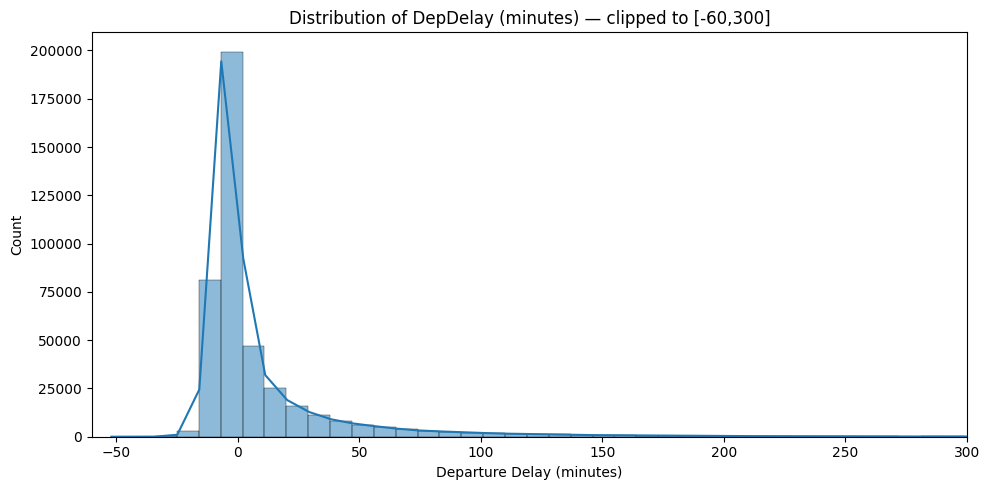

In [66]:
#1) Distribution of DepDelay (hist + KDE)
plt.figure(figsize=(10,5))
sns.histplot(work[target], bins=200, kde=True)
plt.xlim(-60, 300)  # clip extreme axis to make shape readable; change if needed
plt.title("Distribution of DepDelay (minutes) — clipped to [-60,300]")
plt.xlabel("Departure Delay (minutes)")
plt.ylabel("Count")
plt.tight_layout()
plt.show()


Look for right skew (long tail of large positive delays), mass around 0, negative values (early departures).

/tmp/ipython-input-2945924554.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  med_order = (work.groupby('turn_bucket')[target]


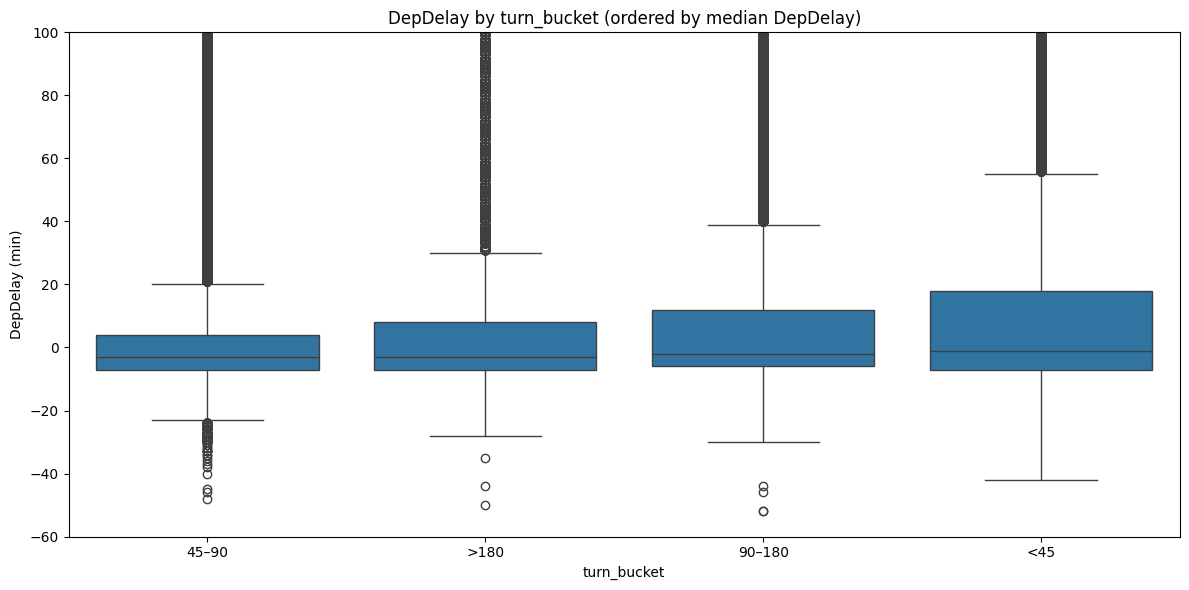

In [67]:
# 2) Boxplot DepDelay by turn_bucket (categorical effect on DepDelay)
if 'turn_bucket' in work.columns:
    plt.figure(figsize=(12,6))
    # order categories by median DepDelay
    med_order = (work.groupby('turn_bucket')[target]
                 .median().sort_values().index.tolist())
    sns.boxplot(x='turn_bucket', y=target, data=work, order=med_order)
    plt.ylim(-60, 100)
    plt.title("DepDelay by turn_bucket (ordered by median DepDelay)")
    plt.xlabel("turn_bucket")
    plt.ylabel("DepDelay (min)")
    plt.tight_layout()
    plt.show()



 If some turn buckets have consistently higher medians/upper tails -> operational turnaround is important.


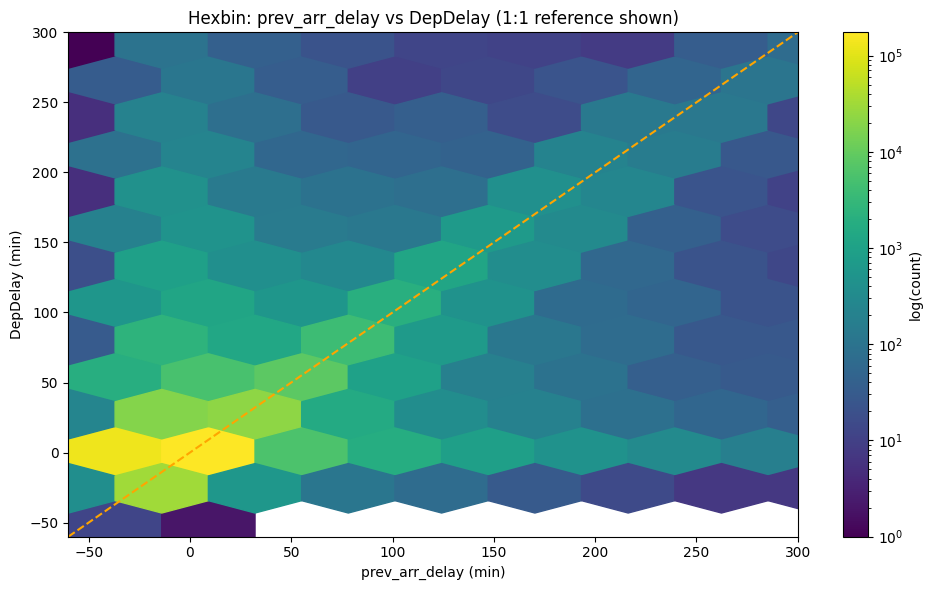

In [68]:
# 3) prev_arr_delay vs DepDelay scatter + regression line (how previous arrival delays propagate) ----

# Variation: use hexbin to handle overplotting if dataset large
plt.figure(figsize=(10,6))
plt.hexbin(work['prev_arr_delay'].fillna(0), work[target], gridsize=60, bins='log')
plt.colorbar(label='log(count)')
plt.plot(np.linspace(-60,300,10), np.linspace(-60,300,10), color='orange', linestyle='--')  # 1:1 line
plt.xlim(-60,300); plt.ylim(-60,300)
plt.title("Hexbin: prev_arr_delay vs DepDelay (1:1 reference shown)")
plt.xlabel("prev_arr_delay (min)")
plt.ylabel("DepDelay (min)")
plt.tight_layout()
plt.show()



Strong positive slope means delays propagate (prev arrival delays cause later departures).

/tmp/ipython-input-1382918636.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  medians = work.groupby(pd.cut(work['Distance'], bins))[target].median()


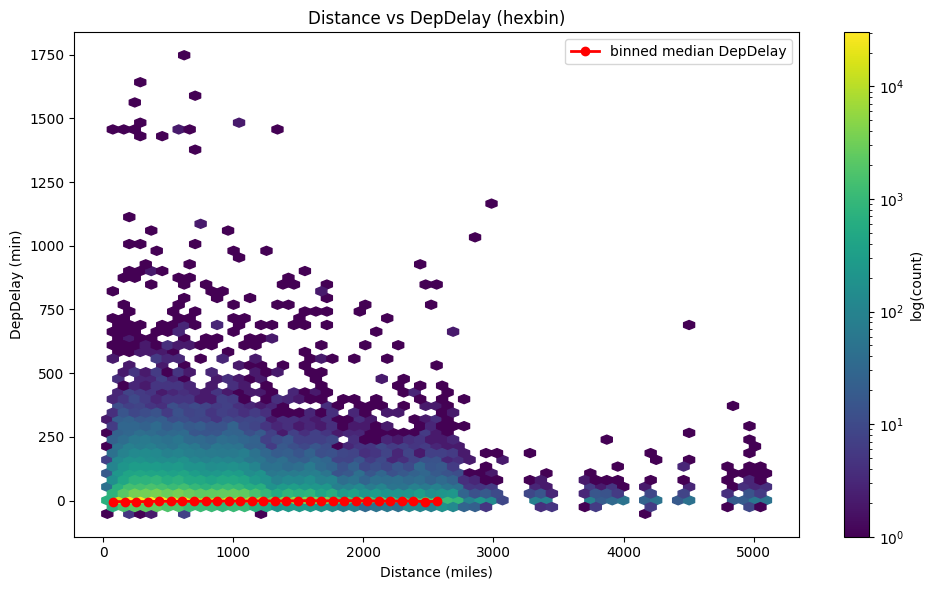

In [69]:
#4) Distance vs DepDelay (hexbin and binned median)
plt.figure(figsize=(10,6))
plt.hexbin(work['Distance'], work[target], gridsize=60, bins='log')
plt.colorbar(label='log(count)')
plt.title("Distance vs DepDelay (hexbin)")
plt.xlabel("Distance (miles)")
plt.ylabel("DepDelay (min)")

# add binned median line
bins = np.linspace(work['Distance'].min(), work['Distance'].quantile(0.99), 30)
medians = work.groupby(pd.cut(work['Distance'], bins))[target].median()
bin_centers = [interval.mid for interval in medians.index.categories]
plt.plot(bin_centers, medians, color='red', marker='o', linewidth=2, label='binned median DepDelay')
plt.legend()
plt.tight_layout()
plt.show()


Long-hauls might have different delay profile (recovery opportunities) vs short hops (more vulnerable).

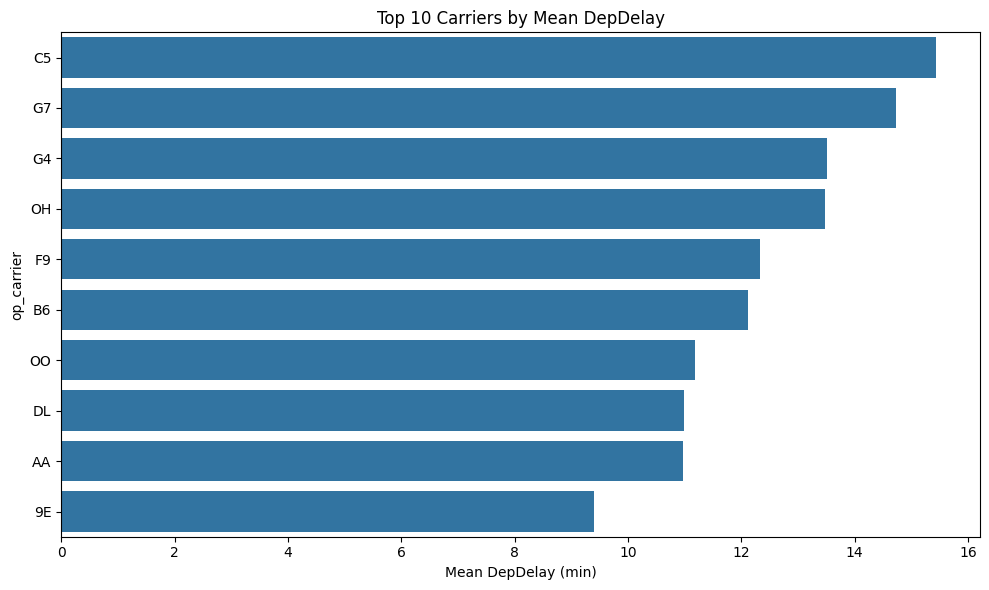

In [70]:
#5) Mean DepDelay by top op_carrier (bar plot)
if 'op_carrier' in work.columns:
    top_carriers = (work.groupby('op_carrier')[target]
                    .mean().sort_values(ascending=False).head(10))
    plt.figure(figsize=(10,6))
    sns.barplot(x=top_carriers.values, y=top_carriers.index)
    plt.xlabel("Mean DepDelay (min)")
    plt.title("Top 10 Carriers by Mean DepDelay")
    plt.tight_layout()
    plt.show()




Carrier operational performance signal. Investigate fleet/route differences for top offenders.

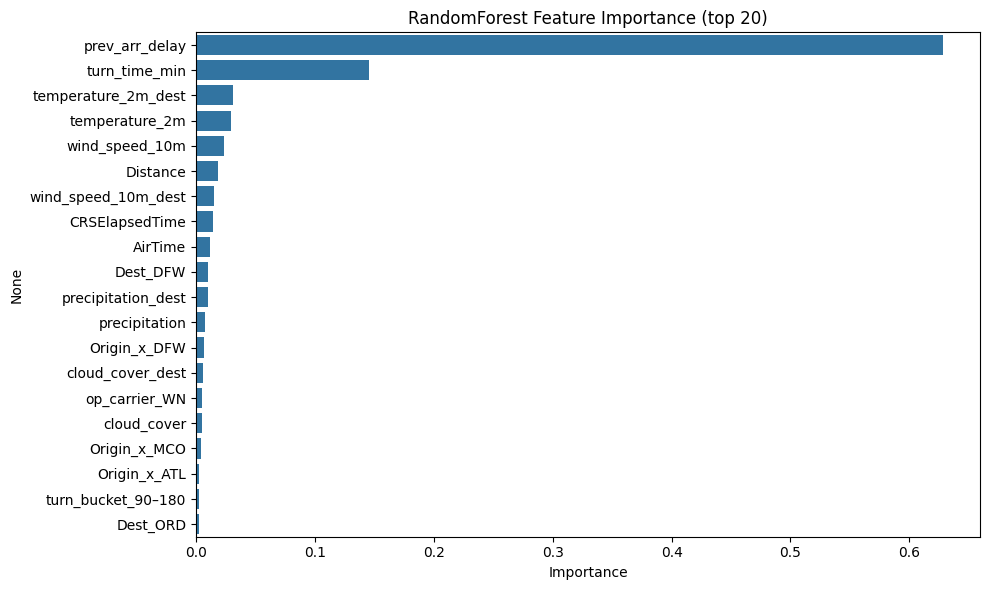

In [71]:
#6) Quick feature-importance (RandomForest) to see which features explain DepDelay best ----
# Select predictive features (numeric + a few categoricals encoded)
features = [
    'prev_arr_delay', 'turn_time_min', 'Distance', 'AirTime', 'CRSElapsedTime',
    'temperature_2m','wind_speed_10m','precipitation','cloud_cover',
    'temperature_2m_dest','wind_speed_10m_dest','precipitation_dest','cloud_cover_dest'
]
# include a few categorical features if present
cat_feats = []
for c in ['turn_bucket','rain_bin','op_carrier','Origin_x','Dest']:
    if c in work.columns:
        cat_feats.append(c)

X = work[features + cat_feats].copy()
y = work[target].copy()

# simple imputation: fillna numeric with median
for col in X.select_dtypes(include=[np.number]).columns:
    X[col] = X[col].fillna(X[col].median())

# one-hot encode small-cardinality categoricals (limit to top categories to avoid explosion)
def one_hot_topk(df, col, k=10):
    topk = df[col].value_counts().nlargest(k).index
    return pd.get_dummies(df[col].where(df[col].isin(topk)), prefix=col, dummy_na=False)

X_encoded = X[features].copy()
for c in cat_feats:
    X_encoded = pd.concat([X_encoded, one_hot_topk(X, c, k=10)], axis=1)

# sample further if still large
if len(X_encoded) > 100000:
    X_enc, _, y_enc, _ = train_test_split(X_encoded, y, train_size=100000, random_state=42)
else:
    X_enc, y_enc = X_encoded, y

# RandomForest for quick importance
rf = RandomForestRegressor(n_estimators=200, max_depth=8, n_jobs=-1, random_state=42)
rf.fit(X_enc, y_enc)
importances = pd.Series(rf.feature_importances_, index=X_enc.columns).sort_values(ascending=False).head(20)

plt.figure(figsize=(10,6))
sns.barplot(x=importances.values, y=importances.index)
plt.title("RandomForest Feature Importance (top 20)")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()




Expect prev_arr_delay and turn_time_min, temperature are the top 3 important features

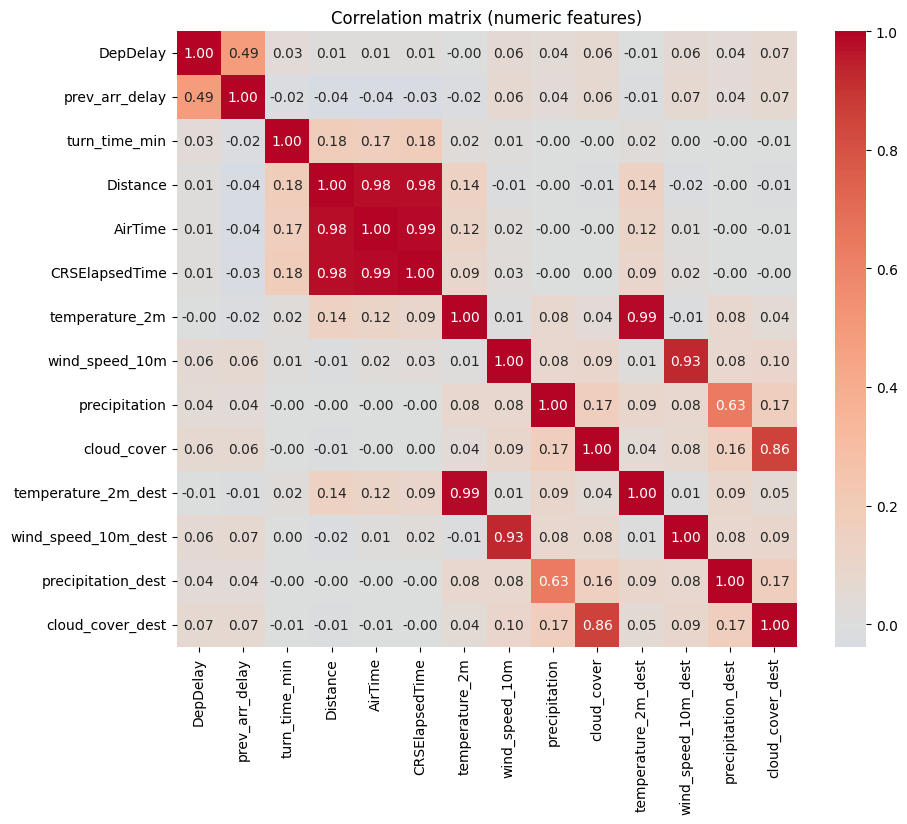

In [75]:
# Compute numeric correlation matrix (limited to numeric columns)
numeric_cols = ['DepDelay','prev_arr_delay','turn_time_min','Distance','AirTime','CRSElapsedTime',
                'temperature_2m','wind_speed_10m','precipitation','cloud_cover',
                'temperature_2m_dest','wind_speed_10m_dest','precipitation_dest','cloud_cover_dest']

corr_df = df[numeric_cols].corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr_df, annot=True, fmt=".2f", cmap='coolwarm', center=0)
plt.title("Correlation matrix (numeric features)")
plt.show()

---

We see that $->$ 'Distance','AirTime', and 'CRSElapsedTime' are highly correlated (>0.8)

Also,'temperature_2m','wind_speed_10m', and 'cloud_cover' are highly correlated (>0.8) with the following, respectively- ' temperature_2m_dest', 'wind_speed_10m_dest', and 'cloud_cover_dest'.

This variables ('AirTime', 'CRSElapsedTime', ' temperature_2m_dest', 'wind_speed_10m_dest', and 'cloud_cover_dest') would be problematic in the case we were running a linear regression model.

However, since we are running prediction systems such as Random Forest and Neural Networks this would not be much of a problem because these models are generally robust to multicollinearity and are primarily focused on optimizing predictive performance rather than interpreting the individual contributions (coefficients) of highly correlated input features.

* Random Forest uses random subsets of features and selects the best split, naturally mitigating redundancy.

* Neural Networks distribute the predictive power across the correlated inputs and their training stability can usually be managed with regularization.

---



# MODELING

In [ ]:
#This file is too big now, which is why the modeling will be in an aditional file. We beg your pardon fot this inconvinience.

In [ ]:
#Please find the developing of the several models in the .zip file.